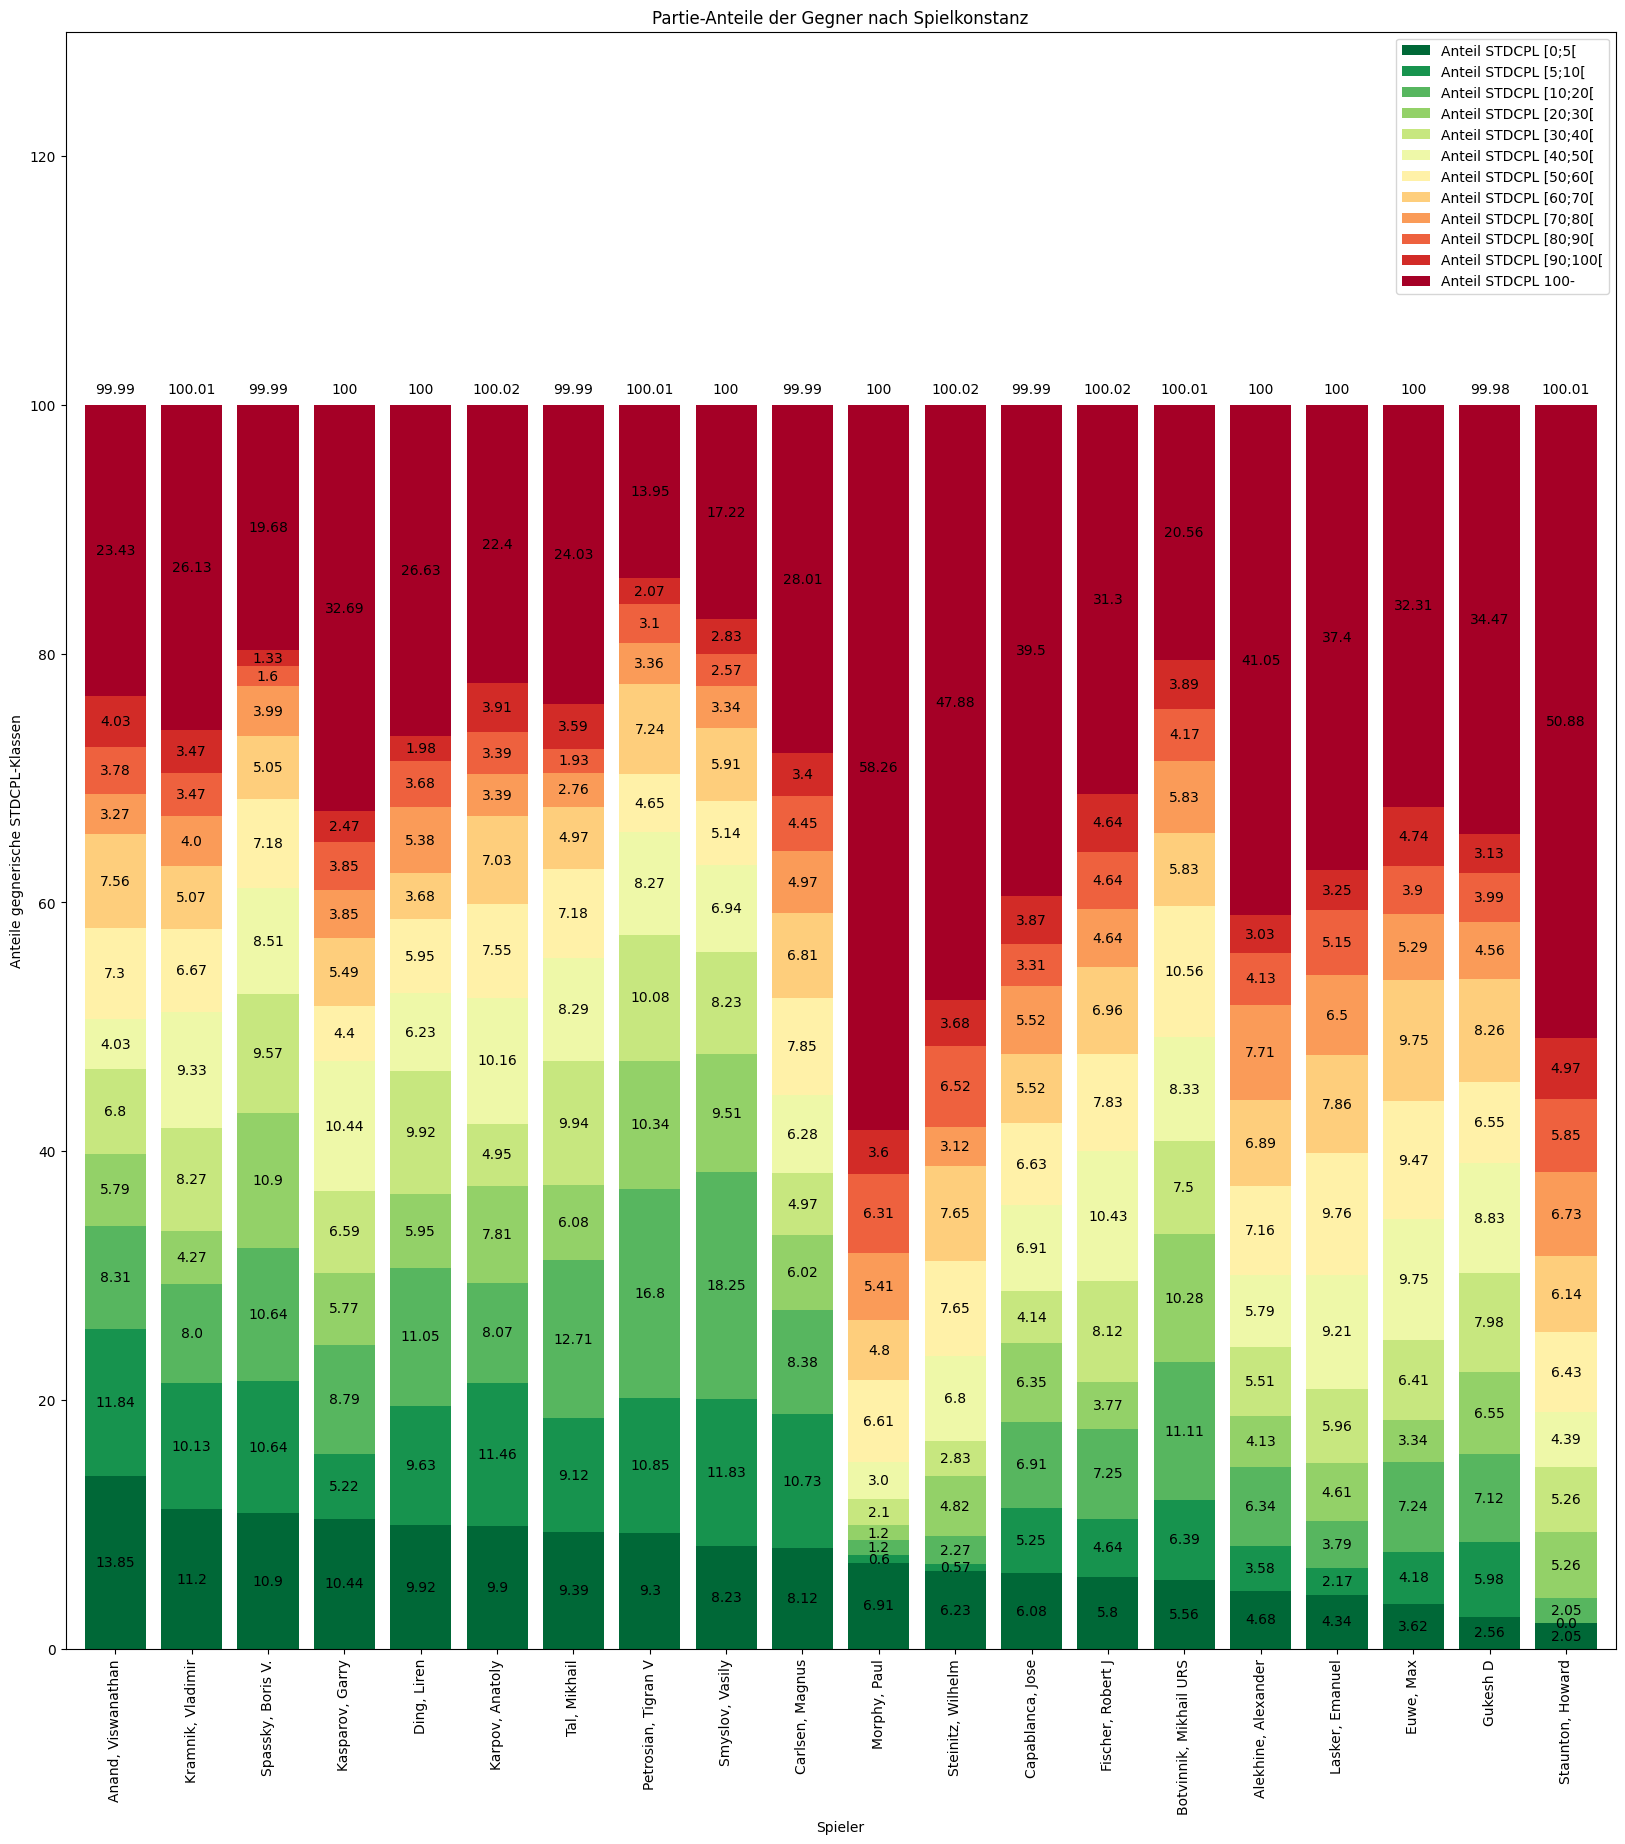

In [2]:
import sys
import os
import getpass
import mariadb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from dotenv import load_dotenv

warnings.filterwarnings('ignore')
    
def connect(p_password):
    global conn
    global cursor
    
    # Database connection details
    db_config = {
        "user": "chess_user",
        "password": p_password,
        "host": "localhost",
        "database": "chess",
        "port": 3306,  # Standard port for MariaDB
    }
    # Establishing the connection
    conn = mariadb.connect(**db_config)
    # Disable autocommit
    conn.autocommit = False
    # Create a cursor to execute queries
    cursor = conn.cursor()

def disconnect():
    cursor.close()
    conn.close()

def get_data():
        df = pd.read_sql_query("""select
	t.spieler "Spieler",
	round(sum(case when t.STDCPLGegner >= 0 and t.STDCPLGegner < 5 then 1 else 0 end) / count(t.spieler) * 100, 2)  "Anteil STDCPL [0;5[",
	round(sum(case when t.STDCPLGegner >= 5 and t.STDCPLGegner < 10 then 1 else 0 end) / count(t.spieler) * 100, 2)  "Anteil STDCPL [5;10[",
	round(sum(case when t.STDCPLGegner >= 10 and t.STDCPLGegner < 20 then 1 else 0 end) / count(t.spieler) * 100, 2)  "Anteil STDCPL [10;20[",
	round(sum(case when t.STDCPLGegner >= 20 and t.STDCPLGegner < 30 then 1 else 0 end) / count(t.spieler) * 100, 2)  "Anteil STDCPL [20;30[",
	round(sum(case when t.STDCPLGegner >= 30 and t.STDCPLGegner < 40 then 1 else 0 end) / count(t.spieler) * 100, 2)  "Anteil STDCPL [30;40[",
	round(sum(case when t.STDCPLGegner >= 40 and t.STDCPLGegner < 50 then 1 else 0 end) / count(t.spieler) * 100, 2)  "Anteil STDCPL [40;50[",
	round(sum(case when t.STDCPLGegner >= 50 and t.STDCPLGegner < 60 then 1 else 0 end) / count(t.spieler) * 100, 2)  "Anteil STDCPL [50;60[",
	round(sum(case when t.STDCPLGegner >= 60 and t.STDCPLGegner < 70 then 1 else 0 end) / count(t.spieler) * 100, 2)  "Anteil STDCPL [60;70[",
	round(sum(case when t.STDCPLGegner >= 70 and t.STDCPLGegner < 80 then 1 else 0 end) / count(t.spieler) * 100, 2)  "Anteil STDCPL [70;80[",
	round(sum(case when t.STDCPLGegner >= 80 and t.STDCPLGegner < 90 then 1 else 0 end) / count(t.spieler) * 100, 2)  "Anteil STDCPL [80;90[",
	round(sum(case when t.STDCPLGegner >= 90 and t.STDCPLGegner < 100 then 1 else 0 end) / count(t.spieler) * 100, 2)  "Anteil STDCPL [90;100[",
	round(sum(case when t.STDCPLGegner >= 100 then 1 else 0 end) / count(t.spieler) * 100, 2)   "Anteil STDCPL 100-"
from
	(
	select
		case
			when p.name in ('Kasparov, Garry', 'Kasparov, G.') then 'Kasparov, Garry'
			when p.name in ('Smyslov, Vasily', 'Smyslov, V.') then 'Smyslov, Vasily'
			else p.name
		end Spieler, 
		nvl(case when p.id = g.white_player_id then dg.stdcpl_black else dg.stdcpl_white end, 0.0) "STDCPLGegner"
	from
		player p
	join game g on
		(p.id = g.black_player_id
			or p.id = g.white_player_id )
	join da_game dg on
		dg.game_id = g.id
	join position po on
		po.game_id = g.id
	join position_analysis pa on
		pa.position_id = po.id
	where 
		p.name in ('Staunton, Howard', 'Morphy, Paul', 'Steinitz, Wilhelm', 'Lasker, Emanuel', 'Capablanca, Jose', 'Alekhine, Alexander', 'Euwe, Max',
'Botvinnik, Mikhail URS', 'Smyslov, Vasily', 'Smyslov, V.', 'Tal, Mikhail', 'Petrosian, Tigran V', 'Spassky, Boris V.', 'Fischer, Robert J', 'Karpov, Anatoly',
'Kasparov, Garry', 'Kasparov, G.', 'Kramnik, Vladimir', 'Anand, Viswanathan', 'Carlsen, Magnus', 'Ding, Liren', 'Gukesh D')
	group by
		case
			when p.name in ('Kasparov, Garry', 'Kasparov, G.') then 'Kasparov, Garry'
			when p.name in ('Smyslov, Vasily', 'Smyslov, V.') then 'Smyslov, Vasily'
			else p.name
		end,
		g.id
) t
group by
	t.spieler
order by 2 desc,
	3 desc,
	4 desc,
	5 desc""", conn)
        return(df)

def visualize_data(p_df): 
    cmap = plt.cm.RdYlGn_r
    colors = cmap(np.linspace(0.0, 1.0, 12))
    ax=p_df.plot(x='Spieler', kind='bar', width=.8, stacked=True, figsize=(20,21), color=colors, ylabel="Anteile gegnerische STDCPL-Klassen", title="Partie-Anteile der Gegner nach Spielkonstanz")
    plt.bar_label(ax.containers[-1], rotation = 0, label_type = "edge", padding=6)
    plt.bar_label(ax.containers[0], labels=p_df['Anteil STDCPL [0;5['], rotation = 0, label_type = "center")
    plt.bar_label(ax.containers[1], labels=p_df['Anteil STDCPL [5;10['], rotation = 0, label_type = "center")
    plt.bar_label(ax.containers[2], labels=p_df['Anteil STDCPL [10;20['], rotation = 0, label_type = "center")
    plt.bar_label(ax.containers[3], labels=p_df['Anteil STDCPL [20;30['], rotation = 0, label_type = "center")
    plt.bar_label(ax.containers[4], labels=p_df['Anteil STDCPL [30;40['], rotation = 0, label_type = "center")
    plt.bar_label(ax.containers[5], labels=p_df['Anteil STDCPL [40;50['], rotation = 0, label_type = "center")
    plt.bar_label(ax.containers[6], labels=p_df['Anteil STDCPL [50;60['], rotation = 0, label_type = "center")
    plt.bar_label(ax.containers[7], labels=p_df['Anteil STDCPL [60;70['], rotation = 0, label_type = "center")
    plt.bar_label(ax.containers[8], labels=p_df['Anteil STDCPL [70;80['], rotation = 0, label_type = "center")
    plt.bar_label(ax.containers[9], labels=p_df['Anteil STDCPL [80;90['], rotation = 0, label_type = "center")
    plt.bar_label(ax.containers[10], labels=p_df['Anteil STDCPL [90;100['], rotation = 0, label_type = "center")
    plt.bar_label(ax.containers[11], labels=p_df['Anteil STDCPL 100-'], rotation = 0, label_type = "center")
    plt.ylim([0, 130])
    plt.show()

    
def main():
    # try to get passwd from .env file
    load_dotenv()
    passwd = os.getenv("passwd")
    
    # If password not provided, prompt securely
    if not passwd:
        try:
            passwd = getpass.getpass(prompt="Enter database password: ")
        except (KeyboardInterrupt, EOFError):
            print("\nPassword input cancelled.")
            sys.exit(1)

    # Validate password input
    if not passwd.strip():
        print("Error: Database password cannot be empty.")
        sys.exit(1)

    # connect to database
    try:
        connect(passwd)
        df = get_data()
        visualize_data(df)
        disconnect()
    except Exception as e:
        print(e)
        try:
            disconnect()
        except:
            pass
        sys.exit(1)


if __name__ == "__main__":
    main()
    
